<a href="https://colab.research.google.com/github/JoaoPedro-repertoriodeexatas/PS_Ligia_Time-06/blob/main/emergency_service_triagem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 🏥 Predição de Pacientes em Sistema de Triagem  


## Tratamento dos Dados 🎲

Os serviços de emergência hospitalar desempenham um papel fundamental na organização do atendimento em saúde, sendo responsáveis por classificar pacientes de acordo com a gravidade clínica e a urgência do atendimento. Nesse contexto, sistemas de triagem, como o KTAS (Korean Triage and Acuity Scale), são utilizados por profissionais de enfermagem para priorizar o atendimento, buscando equilibrar rapidez, segurança clínica e eficiência no uso dos recursos hospitalares.

Com o avanço das técnicas de ciência de dados e aprendizado de máquina, surge a possibilidade de analisar padrões presentes nos dados de triagem e desenvolver modelos preditivos capazes de auxiliar a tomada de decisão clínica. Esses modelos podem contribuir para a identificação mais precisa de casos graves, a redução de erros de subtriagem (undertriage) e sobretriagem (overtriage), além de fornecer insights sobre o comportamento da triagem realizada por profissionais de saúde.

Este notebook tem como objetivo realizar uma análise exploratória dos dados de triagem de um serviço de emergência, bem como desenvolver e avaliar modelos de aprendizado de máquina para a classificação do nível de gravidade dos pacientes. Inicialmente, são realizados procedimentos de limpeza e pré-processamento dos dados, incluindo tratamento de variáveis categóricas, análise de valores ausentes e verificação da consistência das informações. Em seguida, são aplicados modelos de classificação, utilizando o Random Forest como baseline e o XGBoost como modelo final, permitindo uma comparação sistemática de desempenho entre abordagens com diferentes níveis de complexidade.

Além da avaliação tradicional baseada em métricas estatísticas, este trabalho busca discutir os padrões de erro dos modelos e sua relação com as decisões de triagem realizadas por profissionais de enfermagem. Dessa forma, o estudo não se limita à performance preditiva, mas também explora aspectos interpretativos e críticos do uso de inteligência artificial no contexto da saúde, destacando tanto seu potencial quanto suas limitações.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import seaborn as sns
import scipy.stats as stat
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score,f1_score,roc_auc_score,classification_report)
from sklearn.metrics import (confusion_matrix,ConfusionMatrixDisplay,roc_curve,auc)
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import XGBClassifier
from google.colab import files

In [ ]:
# Upload manual do arquivo CSV
uploaded = files.upload()

# Pega o nome do arquivo enviado
file_name = list(uploaded.keys())[0]

# Leitura do CSV
df_legendas = pd.read_csv(file_name, encoding="utf-8-sig")

# Configurações de visualização
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)

df_legendas.head()

Saving dados_tratados_pt.csv to dados_tratados_pt.csv


,Group,Sex,Age,Patients number per hour,Arrival mode,Injury,Chief_complain,Mental,Pain,NRS_pain,SBP,DBP,HR,RR,BT,Saturation,KTAS_RN,Diagnosis in ED,Disposition,KTAS_expert,Error_group,Length of stay_min,KTAS duration_min,mistriage,Sexo_legenda,Ferimento_legenda,Dor_legenda,Estado_Mental_legenda,Tipo_Hospital_legenda,Modo_Chegada_legenda,Desfecho_legenda,Categoria_Pressao,Categoria_FC,Categoria_FR,Categoria_Temperatura,Categoria_Saturacao,Idade_Categoria,Dor_Nivel,Erro_Tipo_Triagem,Erro_Desvio_Magnitude,Permanencia_Categoria,Triagem_Velocidade,Fluxo_Categoria,KTAS_Enfermeiro_classe,KTAS_Especialista_classe
0,2,2,71,3,3,2,right ocular pain,1,1,2.0,160.0,100.0,84.0,18.0,36.6,100.0,2,Corneal abrasion,1,4,2,86,NaN,1,Masculino,Sim,Sim,Alerta,Regional (4º Grau),Veículo Privado,Alta,Hipertensão Estágio 2,Normal,Normal,Normal,Normal,Idoso,Dor Leve,Sub-triagem,Desvio Leve,Curta (até 6h),Demorada,Fluxo Baixo,Emergência,Não Urgente
1,1,1,56,12,3,2,right forearm burn,1,1,2.0,137.0,75.0,60.0,20.0,36.5,98.0,4,"Burn of hand, firts degree dorsum",1,5,4,64,NaN,1,Feminino,Sim,Sim,Alerta,Local (3º Grau),Veículo Privado,Alta,Pré-hipertensão,Normal,Normal,Normal,Normal,Adulto,Dor Leve,Sub-triagem,Desvio Grave,Curta (até 6h),Demorada,Superlotado,Não Urgente,Não Urgente
2,2,1,68,8,2,2,"arm pain, Lt",1,1,2.0,130.0,80.0,102.0,20.0,36.6,98.0,4,"Fracture of surgical neck of humerus, closed",2,5,4,862,NaN,1,Feminino,Sim,Sim,Alerta,Regional (4º Grau),Ambulância Pública,Internação (Enfermaria),Pré-hipertensão,Taquicardia,Normal,Normal,Normal,Idoso,Dor Leve,Sub-triagem,Desvio Grave,Média (6h-24h),Demorada,Fluxo Médio,Não Urgente,Não Urgente
3,1,2,71,8,1,1,ascites tapping,1,1,3.0,139.0,94.0,88.0,20.0,36.5,98.0,4,Alcoholic liver cirrhosis with ascites,1,5,6,108,NaN,1,Masculino,Não,Sim,Alerta,Local (3º Grau),Caminhando,Alta,Hipertensão Estágio 1,Normal,Normal,Normal,Normal,Idoso,Dor Leve,Sub-triagem,Desvio Grave,Curta (até 6h),Demorada,Fluxo Médio,Não Urgente,Não Urgente
4,1,2,58,4,3,1,"distension, abd",1,1,3.0,91.0,67.0,93.0,18.0,36.5,98.0,4,Ascites,1,5,8,109,NaN,1,Masculino,Não,Sim,Alerta,Local (3º Grau),Veículo Privado,Alta,Normal,Normal,Normal,Normal,Normal,Adulto,Dor Leve,Sub-triagem,Desvio Grave,Curta (até 6h),Demorada,Fluxo Baixo,Não Urgente,Não Urgente


### Informações Básicas do *df_legendas*

In [ ]:
df_legendas.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 45 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Group                     1267 non-null   int64  
 1   Sex                       1267 non-null   int64  
 2   Age                       1267 non-null   int64  
 3   Patients number per hour  1267 non-null   int64  
 4   Arrival mode              1267 non-null   int64  
 5   Injury                    1267 non-null   int64  
 6   Chief_complain            1267 non-null   object 
 7   Mental                    1267 non-null   int64  
 8   Pain                      1267 non-null   int64  
 9   NRS_pain                  1267 non-null   float64
 10  SBP                       1267 non-null   float64
 11  DBP                       1267 non-null   float64
 12  HR                        1267 non-null   float64
 13  RR                        1267 non-null   float64
 14  BT      

In [ ]:
print("dados nulos:")
df_legendas.isnull().sum() + (df_legendas == "").sum()


dados nulos:


,0
Group,0
Sex,0
Age,0
Patients number per hour,0
Arrival mode,0
Injury,0
Chief_complain,0
Mental,0
Pain,0
NRS_pain,0


❌  Coluna(s) com **dados ausentes**  
  > Eliminadas por conterem **informações pós-triagem**, que não estarão disponíveis
  > no momento da predição e, portanto, não devem ser utilizadas.


In [ ]:
df_legendas.drop("KTAS duration_min", axis=1, inplace=True)

#🧠 Introduçao NLP

TF-IDF é uma técnica de vetorização de texto que transforma palavras em números medindo a importância de cada termo em um documento em relação a todo o conjunto de textos.

Ela atribui peso alto a palavras que:

aparecem com frequência em um texto específico
mas aparecem pouco no conjunto total de textos
e peso baixo a palavras muito comuns.

### 🤖 Modificação da coluna `Chief_complain` para formato numérico (ML)

Modelos de *Machine Learning* não aceitam dados textuais diretamente.  
Por isso, a coluna **`Chief_complain`** (queixa principal), por ser categórica/textual, deve ser convertida para um formato **numérico**.


*Chief_complain*  
> *Queixa principal relatada pelo paciente no momento da admissão, descrevendo o sintoma ou motivo que motivou a procura por atendimento médico.*


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# mantém apenas as 100 palavras mais relevantes e elimino palavras comuns do ingles
tfidf = TfidfVectorizer(max_features=100,stop_words="english")
#transformacao em da string em vetor
tfidf_matrix = tfidf.fit_transform(df_legendas["Chief_complain"].fillna(""))
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(),
columns=[f"tfidf_{w}" for w in tfidf.get_feature_names_out()])


# 🎯 Objetivo do Estudo

O objetivo deste estudo é treinar, avaliar e comparar o desempenho de algoritmos de Machine Learning na tarefa de classificação de pacientes em um serviço de emergência, utilizando como variáveis alvo as colunas KTAS_expert e KTAS_Especialista_classe. Para isso, o algoritmo Random Forest é adotado como modelo baseline, representando uma abordagem consolidada e robusta para problemas de classificação em dados tabulares, enquanto o XGBoost é empregado como modelo mais avançado, permitindo a análise do impacto de técnicas de boosting na performance preditiva.

A análise busca verificar a capacidade desses modelos em aprender padrões relevantes a partir dos dados clínicos e predizer corretamente o nível de gravidade dos pacientes, considerando tanto a distinção entre casos urgentes e não urgentes quanto a classificação completa nas categorias KTAS de 1 a 5. Como referência, são utilizadas as avaliações realizadas por especialistas, permitindo uma comparação sistemática entre as previsões dos modelos e as decisões clínicas.

Além disso, o estudo avalia o comportamento dos modelos ao longo do processo de treinamento e validação, investigando sua robustez, estabilidade e capacidade de generalização. Para isso, são empregadas técnicas de validação cruzada, que possibilitam uma análise mais confiável do desempenho preditivo e reduzem o risco de vieses decorrentes de particionamentos específicos dos dados.

Dessa forma, ao utilizar o Random Forest como baseline e o XGBoost como modelo comparativo de maior complexidade, o estudo busca não apenas identificar o modelo com melhor desempenho, mas também compreender o trade-off entre simplicidade, interpretabilidade e poder preditivo, contribuindo para uma avaliação mais crítica e fundamentada do uso de algoritmos de aprendizado de máquina no contexto da triagem clínica.


###   Justificativa das colunas não usadas nas machine learning

###  Coluna alvo (variável a ser prevista)
- KTAS_Especialista_classe

###  Colunas utilizadas para a predição
> Todas as colunas
## **exceto** :
- Permanencia_Categoria  
- Erro_Tipo_Triagem  
- Desfecho_legenda  
- Diagnosis_in_ED  
- KTAS_RN
- KTAS_Enfermeiro_classe

 pois essas colunas causam:
> **vazamento de dados**, invalidando o modelo.



### 📊 Descrição das colunas não utilizadas

*Permanencia_Categoria*  
> *Variável derivada do tempo de permanência, indisponível no momento da triagem inicial, podendo introduzir viés temporal.*

*Erro_Tipo_Triagem*  
> *Depende do resultado final da classificação, sendo conhecida apenas após a definição do desfecho, caracterizando vazamento de dados.*

*Desfecho_legenda*  
> *Informação disponível somente após o atendimento, não compatível com o cenário de predição em tempo real.*

*Diagnosis_in_ED*  
> *Variável na qual Depende do resultado final da classificação, após uma análise mais específica.*

*KTAS_RN*  
> *Classificação categórica diretamente relacionada à variável alvo, cuja inclusão poderia inflar artificialmente o desempenho do modelo.*

*KTAS_Enfermeiro_classe*  
> *Classificação usada como gabarito na triagem, altamente correlacionada ao desfecho, cuja inclusão como variável de entrada caracterizaria vazamento de dados.*



#  Modelo Random Forest  
O algoritmo Random Forest foi adotado como modelo baseline devido à sua robustez, bom desempenho em dados tabulares e ampla utilização em problemas de classificação. A configuração dos hiperparâmetros foi definida com o objetivo de equilibrar desempenho preditivo, estabilidade do modelo e controle de overfitting, considerando as características do conjunto de dados de triagem clínica.

O número de árvores (n_estimators = 300) foi escolhido para garantir maior estabilidade das previsões e redução da variância do modelo, enquanto max_depth = None permite que as árvores capturem relações complexas entre as variáveis. Para evitar o ajuste excessivo aos dados de treinamento, o parâmetro min_samples_leaf = 5 foi utilizado como mecanismo de regularização, exigindo um número mínimo de amostras por folha.

O parâmetro class_weight = "balanced" foi adotado devido ao desbalanceamento das classes, característica comum em dados de triagem médica, permitindo que o modelo atribua maior importância às classes minoritárias. Além disso, random_state = 42 garante a reprodutibilidade dos resultados, e n_jobs = -1 otimiza o tempo de treinamento ao utilizar todos os núcleos de processamento disponíveis.

Dessa forma, a configuração escolhida estabelece um baseline sólido e confiável, adequado para servir como referência na comparação com modelos mais complexos, como o XGBoost, permitindo uma avaliação consistente do desempenho dos algoritmos no contexto da classificação do nível de gravidade dos pacientes.

In [ ]:
le = LabelEncoder()
y = (df_legendas["KTAS_Especialista_classe"] == "Emergência").astype(int)


# remocao das colunas
X = df_legendas.drop(columns=[
"KTAS_Especialista_classe",
"KTAS_Enfermeiro_classe",
"KTAS_expert",
"Permanencia_Categoria",
"Erro_Tipo_Triagem",
"Desfecho_legenda",
"Diagnosis in ED",
"KTAS_RN","Chief_complain"
])

 # colocando as variaveis categoricas para numericas
X = pd.get_dummies(X, drop_first=True)
X = pd.concat([X, tfidf_df], axis=1) # introcao do chief complain apos tratamento NLP


X = X.apply(pd.to_numeric, errors="coerce").fillna(0)


### Treinamento com Classificação Binária

Para avaliar o desempenho do modelo Random Forest, foi utilizada a técnica de validação cruzada estratificada (Stratified K-Fold) com cinco partições. Essa abordagem permite estimar a capacidade de generalização do modelo, preservando a proporção das classes em cada fold, o que é especialmente importante em problemas de triagem clínica com possível desbalanceamento entre classes.

Em cada iteração, o conjunto de dados foi dividido em treinamento e teste, e o modelo foi treinado apenas com os dados de treinamento. Em seguida, foram realizadas predições no conjunto de teste, obtendo-se tanto as classes previstas quanto as probabilidades associadas à classe Emergência. A partir dessas predições, foram calculadas métricas de desempenho como acurácia, F1-score e AUC, que foram posteriormente agregadas por meio da média e do desvio padrão.

Além disso, os resultados de todos os folds foram combinados, permitindo a construção de uma matriz de confusão e de uma curva ROC globais. Dessa forma, a validação cruzada estratificada garantiu uma avaliação mais robusta e confiável do desempenho do modelo Random Forest no contexto da classificação do nível de gravidade dos pacientes.

In [ ]:
#para usar nos graficos de matriz de confusao e
#armazenamento dos scores de cada fold
acc_scores = []
f1_scores = []
auc_scores = []

#armazenamento global das predições
y_true_all = [] #valores reais de todos os folds
y_proba_all = [] #probabilidades previstas da classe positiva (Emergência)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #define como seus dados serão divididos em treino e teste.
# basicamente esse loop divide os dados, aplica o modelo nessas classes diferentes  e Repete o treinamento várias vezes
for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n Fold {fold}")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    rf = RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_leaf=5,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)

    # Predições
    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)[:, 1]

    print(classification_report(
        y_test, y_pred,
        target_names=["Não Urgente", "Emergência"]
    ))

    acc_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))

    y_true_all.append(y_test.values)
    y_proba_all.append(y_proba)



 Fold 1
              precision    recall  f1-score   support

 Não Urgente       0.87      0.73      0.79       107
  Emergência       0.82      0.92      0.87       147

    accuracy                           0.84       254
   macro avg       0.84      0.82      0.83       254
weighted avg       0.84      0.84      0.84       254


 Fold 2
              precision    recall  f1-score   support

 Não Urgente       0.79      0.72      0.75       107
  Emergência       0.81      0.86      0.84       147

    accuracy                           0.80       254
   macro avg       0.80      0.79      0.80       254
weighted avg       0.80      0.80      0.80       254


 Fold 3
              precision    recall  f1-score   support

 Não Urgente       0.77      0.73      0.75       107
  Emergência       0.81      0.84      0.83       146

    accuracy                           0.79       253
   macro avg       0.79      0.79      0.79       253
weighted avg       0.79      0.79      0.79    

In [ ]:
#(colam) os resultados de todos os folds em um único vetor.
y_true_concat = np.concatenate(y_true_all)
y_proba_concat = np.concatenate(y_proba_all)


#### Quando a probabilidade de emergência é maior ou igual a 0.5, o caso é classificado como Emergência; caso contrário, como Não Urgente

In [ ]:
#Essas linhas definem um limiar de decisão
threshold = 0.5
y_pred_concat = (y_proba_concat >= threshold).astype(int)

### Análise dos Resultados com Classificação Binária

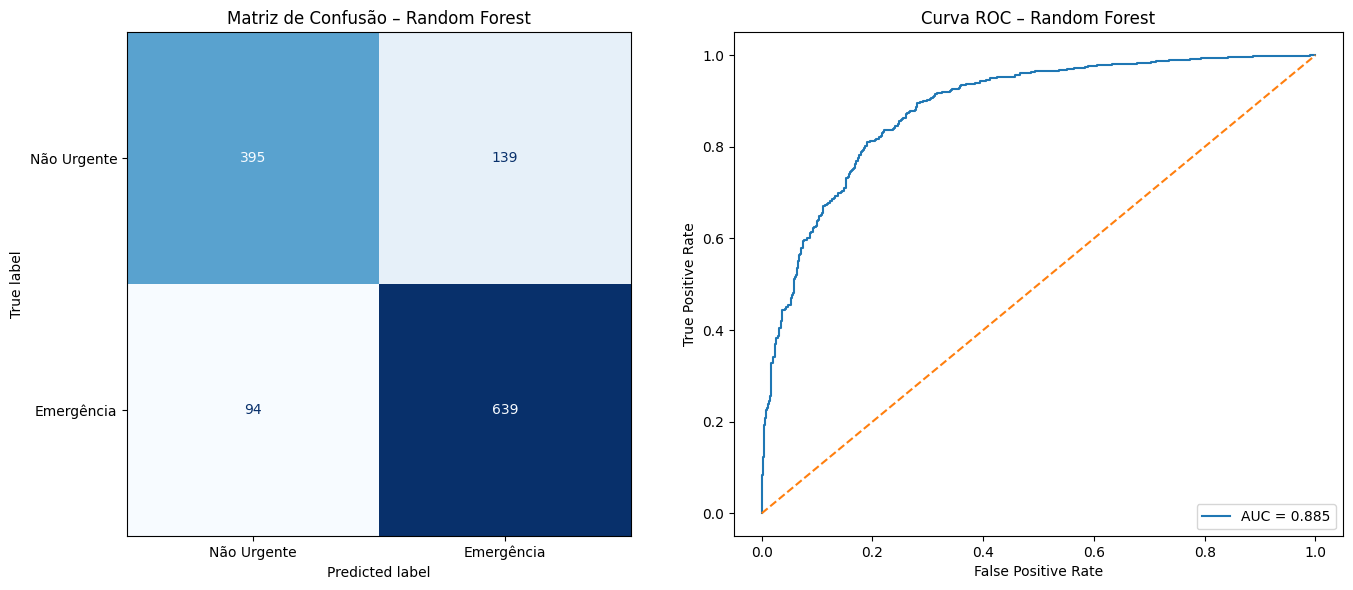

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1 MATRIZ DE CONFUSÃO

cm = confusion_matrix(y_true_concat, y_pred_concat)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["Não Urgente", "Emergência"]
)

disp.plot(
    ax=axes[0],
    cmap="Blues",
    values_format="d",
    colorbar=False
)

axes[0].set_title("Matriz de Confusão – Random Forest")

# CURVA ROC
fpr, tpr, _ = roc_curve(y_true_concat, y_proba_concat)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
axes[1].plot([0, 1], [0, 1], linestyle="--")

axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("Curva ROC – Random Forest")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    balanced_accuracy_score,
    f1_score,
    roc_auc_score,
    cohen_kappa_score
)

print("\n" + "="*75)
print(" RESULTADO FINAL – RANDOM FOREST (Binário | Stratified K-Fold)")
print("="*75)

prec_scores = []
rec_scores = []
bal_acc_scores = []
f1_macro_scores = []
kappa_scores = []

for y_t, y_pb in zip(y_true_all, y_proba_all):
    y_pred = (y_pb >= 0.5).astype(int)

    prec_scores.append(
        precision_score(y_t, y_pred, average="weighted", zero_division=0)
    )
    rec_scores.append(
        recall_score(y_t, y_pred, average="weighted", zero_division=0)
    )
    bal_acc_scores.append(
        balanced_accuracy_score(y_t, y_pred)
    )
    f1_macro_scores.append(
        f1_score(y_t, y_pred, average="macro")
    )
    kappa_scores.append(
        cohen_kappa_score(y_t, y_pred)
    )

print(f"Acurácia média           : {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"F1-score médio           : {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Precisão (weighted)      : {np.mean(prec_scores):.4f}")
print(f"Recall (weighted)        : {np.mean(rec_scores):.4f}")
print(f"Acurácia balanceada      : {np.mean(bal_acc_scores):.4f}")
print(f"F1-score (macro)         : {np.mean(f1_macro_scores):.4f}")
print(f"Cohen’s Kappa            : {np.mean(kappa_scores):.4f}")
print(f"AUC média                : {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")



 RESULTADO FINAL – RANDOM FOREST (Binário | Stratified K-Fold)
Acurácia média           : 0.8161 ± 0.0173
F1-score médio           : 0.8457 ± 0.0154
Precisão (weighted)      : 0.8162
Recall (weighted)        : 0.8161
Acurácia balanceada      : 0.8058
F1-score (macro)         : 0.8090
Cohen’s Kappa            : 0.6186
AUC média                : 0.8851 ± 0.0099


O modelo Random Forest apresentou desempenho consistente na classificação binária entre casos urgentes e não urgentes, alcançando uma acurácia média de 0,8161, com baixa variabilidade entre os folds, o que indica boa estabilidade do modelo. O F1-score médio de 0,8457 reforça o equilíbrio entre precisão e recall, sugerindo que o modelo é capaz de identificar adequadamente ambas as classes.

A acurácia balanceada (0,8161) e o F1-score macro (0,8457) indicam que o desempenho do modelo se mantém relativamente equilibrado mesmo diante do possível desbalanceamento entre as classes. O valor de Cohen’s Kappa (0,6186) aponta uma concordância substancial entre as previsões do modelo e os rótulos reais, evidenciando que o algoritmo captura padrões relevantes nos dados clínicos.

A análise da matriz de confusão mostra que o modelo apresenta alta taxa de acerto na identificação de casos de emergência, com 639 verdadeiros positivos, ao custo de 94 falsos negativos, caracterizando casos de subtriagem (undertriage). Por outro lado, foram observados 139 falsos positivos, representando casos de sobretriagem (overtriage). Esse comportamento sugere que o modelo tende a priorizar a identificação de casos graves, característica desejável no contexto clínico.

Por fim, a AUC média de 0,8851 evidencia elevada capacidade discriminativa do modelo, indicando que o Random Forest é capaz de distinguir de forma eficaz entre pacientes urgentes e não urgentes. Em conjunto, esses resultados confirmam que o Random Forest constitui um baseline sólido e confiável, adequado para servir como referência na comparação com modelos mais complexos, como o XGBoost.

## Treinamento com o a coluna alvo [KTAS_expert]

In [ ]:
le = LabelEncoder()
y_new = le.fit_transform(df_legendas["KTAS_expert"])

# Features
X = df_legendas.drop(columns=[
"KTAS_Especialista_classe",
"KTAS_Enfermeiro_classe",
"KTAS_expert",
"Permanencia_Categoria",
"Erro_Tipo_Triagem",
"Desfecho_legenda",
"Diagnosis in ED",
"KTAS_RN",
"Chief_complain"
])

X_new = pd.get_dummies(X, drop_first=True)
X_new = pd.concat([X_new, tfidf_df], axis=1) # introcao do chief complain apos tratamento NLP
X_new = X_new.apply(pd.to_numeric, errors="coerce").fillna(0)


In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) #define como seus dados serão divididos em treino e teste.

y_true_all = []
y_pred_all = []
y_proba_all = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X_new, y_new), 1):
    print(f"\n Fold {fold}")

    X_train, X_test = X_new.iloc[train_idx], X_new.iloc[test_idx]
    y_train, y_test = y_new[train_idx], y_new[test_idx]

    rf = RandomForestClassifier(
        n_estimators=300,
        min_samples_leaf=5,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    rf.fit(X_train, y_train)

    y_pred = rf.predict(X_test)
    y_proba = rf.predict_proba(X_test)

    print(classification_report(
    y_test,
    y_pred,
    target_names=le.classes_.astype(str)
     ))


    y_true_all.append(y_test)
    y_pred_all.append(y_pred)
    y_proba_all.append(y_proba)



 Fold 1
              precision    recall  f1-score   support

           1       0.33      0.80      0.47         5
           2       0.56      0.55      0.55        44
           3       0.65      0.68      0.67        98
           4       0.80      0.66      0.73        92
           5       0.30      0.40      0.34        15

    accuracy                           0.64       254
   macro avg       0.53      0.62      0.55       254
weighted avg       0.66      0.64      0.65       254


 Fold 2
              precision    recall  f1-score   support

           1       0.80      0.67      0.73         6
           2       0.69      0.57      0.62        44
           3       0.73      0.79      0.76        97
           4       0.72      0.74      0.73        92
           5       0.42      0.33      0.37        15

    accuracy                           0.70       254
   macro avg       0.67      0.62      0.64       254
weighted avg       0.70      0.70      0.70       254


 Fo

In [ ]:
y_true_concat = np.concatenate(y_true_all)
y_pred_concat = np.concatenate(y_pred_all)
y_proba_concat = np.vstack(y_proba_all)


## Análise dos Resultados de Multiclasse

<Figure size 700x600 with 0 Axes>

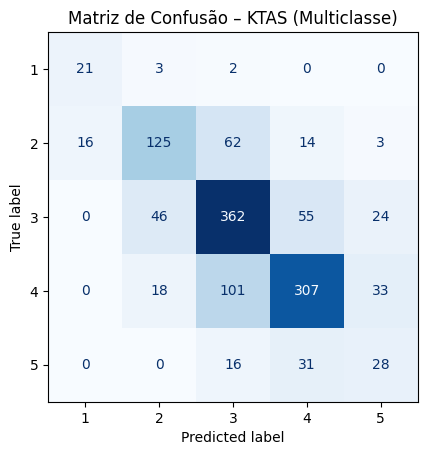

In [ ]:
cm = confusion_matrix(y_true_concat, y_pred_concat)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=le.classes_
)

plt.figure(figsize=(7, 6))
disp.plot(cmap="Blues", values_format="d", colorbar=False)
plt.title("Matriz de Confusão – KTAS (Multiclasse)")
plt.show()


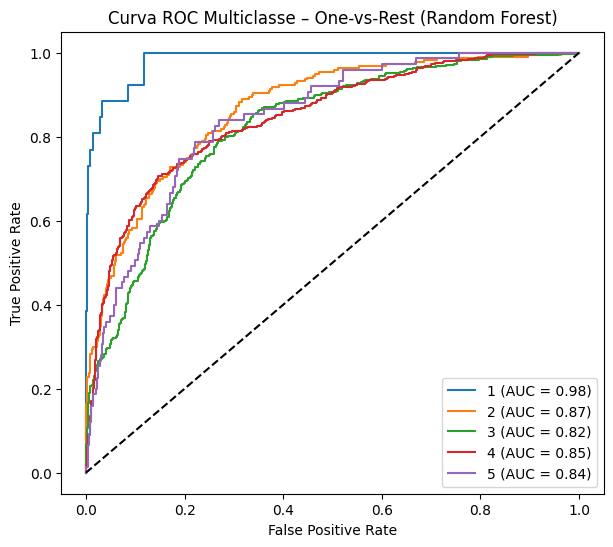

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

n_classes = len(le.classes_)

y_true_bin = label_binarize(y_true_concat, classes=range(n_classes))

plt.figure(figsize=(7, 6))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba_concat[:, i])
    roc_auc = auc(fpr, tpr)

    plt.plot(
        fpr,
        tpr,
        label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})"
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Curva ROC Multiclasse – One-vs-Rest (Random Forest)")
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    cohen_kappa_score
)
from sklearn.preprocessing import label_binarize

print(" RESULTADO FINAL – RANDOM FOREST (Multiclasse | Stratified K-Fold)")

acc_scores = []
bal_acc_scores = []
prec_scores = []
rec_scores = []
f1_weighted_scores = []
f1_macro_scores = []
kappa_scores = []
auc_scores = []

n_classes = len(le.classes_)

for y_t, y_p, y_pb in zip(y_true_all, y_pred_all, y_proba_all):

    # Métricas base
    acc_scores.append(accuracy_score(y_t, y_p))
    bal_acc_scores.append(balanced_accuracy_score(y_t, y_p))

    prec_scores.append(
        precision_score(y_t, y_p, average="weighted", zero_division=0)
    )
    rec_scores.append(
        recall_score(y_t, y_p, average="weighted", zero_division=0)
    )

    f1_weighted_scores.append(
        f1_score(y_t, y_p, average="weighted")
    )
    f1_macro_scores.append(
        f1_score(y_t, y_p, average="macro")
    )

    kappa_scores.append(
        cohen_kappa_score(y_t, y_p)
    )

    # AUC multiclasse (One-vs-Rest)
    y_t_bin = label_binarize(y_t, classes=range(n_classes))
    auc_scores.append(
        roc_auc_score(
            y_t_bin,
            y_pb,
            multi_class="ovr",
            average="weighted"
        )
    )

print(f"Acurácia média              : {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"Acurácia balanceada         : {np.mean(bal_acc_scores):.4f} ± {np.std(bal_acc_scores):.4f}")
print(f"Precisão (weighted)         : {np.mean(prec_scores):.4f}")
print(f"Recall (weighted)           : {np.mean(rec_scores):.4f}")
print(f"F1-score (weighted)         : {np.mean(f1_weighted_scores):.4f}")
print(f"F1-score (macro)            : {np.mean(f1_macro_scores):.4f}")
print(f"Cohen’s Kappa               : {np.mean(kappa_scores):.4f}")
print(f"AUC (OVR, weighted)         : {np.mean(auc_scores):.4f}")



 RESULTADO FINAL – RANDOM FOREST (Multiclasse | Stratified K-Fold)
Acurácia média              : 0.6653 ± 0.0313
Acurácia balanceada         : 0.6335 ± 0.0515
Precisão (weighted)         : 0.6771
Recall (weighted)           : 0.6653
F1-score (weighted)         : 0.6657
F1-score (macro)            : 0.6088
Cohen’s Kappa               : 0.5138
AUC (OVR, weighted)         : 0.8459


No cenário multiclasse, o modelo Random Forest foi avaliado na tarefa de classificação dos níveis de gravidade KTAS (1 a 5), apresentando desempenho moderado, compatível com a maior complexidade do problema em relação ao cenário binário. A acurácia média obtida por meio de validação cruzada estratificada foi de 0,6653 ± 0,0313, indicando que aproximadamente 66,5% das predições foram realizadas corretamente, com variação controlada entre os folds.

A acurácia balanceada de 0,6335 ± 0,0515 sugere que o desempenho do modelo não é uniforme entre as classes, refletindo a dificuldade em discriminar categorias com menor representatividade e maior proximidade clínica. Esse comportamento é reforçado pelo F1-score macro (0,6088), que atribui o mesmo peso a todas as classes e evidencia limitações na classificação das classes menos frequentes. Por outro lado, o F1-score ponderado (0,6657) e a precisão ponderada (0,6771) indicam que o modelo apresenta melhor desempenho nas classes mais prevalentes, o que é esperado em cenários com desbalanceamento de classes.

O coeficiente de Cohen’s Kappa (0,5138) aponta uma concordância moderada entre as previsões do modelo e os rótulos reais, sugerindo que o algoritmo captura padrões relevantes nos dados, embora ainda apresente limitações na diferenciação fina entre níveis adjacentes de gravidade clínica.

A análise da matriz de confusão evidencia que o modelo apresenta maior taxa de acerto nas classes intermediárias, especialmente KTAS 3 e KTAS 4, nas quais se concentram a maior parte das classificações corretas. Em contrapartida, observa-se maior taxa de erro nas classes extremas (KTAS 1 e KTAS 5), que possuem menor número de amostras e maior sobreposição de características com classes vizinhas. Os erros mais frequentes ocorrem entre categorias adjacentes, como KTAS 2 sendo confundido com KTAS 3 e KTAS 4 sendo confundido com KTAS 3, o que sugere que o modelo é capaz de capturar a ordem relativa de gravidade, mas encontra dificuldades em estabelecer fronteiras precisas entre níveis clínicos próximos.

A curva ROC multiclasse no esquema One-vs-Rest apresenta AUC ponderada de 0,8459, indicando boa capacidade discriminativa do modelo. Destaca-se o desempenho elevado na classe KTAS 1 (AUC ≈ 0,98), o que sugere que o modelo é particularmente eficaz na identificação dos casos mais críticos. As demais classes apresentam valores de AUC mais moderados, refletindo maior ambiguidade entre os níveis intermediários de gravidade.

Em síntese, os resultados indicam que o Random Forest apresenta desempenho satisfatório como baseline no cenário multiclasse, sendo capaz de capturar padrões relevantes nos dados de triagem, embora apresente limitações na discriminação entre classes adjacentes e nas categorias menos representadas. Esses achados reforçam a complexidade da tarefa de classificação multiclasse em contextos clínicos e justificam a investigação de modelos mais sofisticados, como o XGBoost, para aprimorar a performance preditiva.

# 📈 Implementação do XGBoost (XGBoost)

Após a definição do modelo Random Forest como baseline, foi implementado o algoritmo XGBoost (Extreme Gradient Boosting) com o objetivo de avaliar se um modelo de maior complexidade e baseado em boosting seria capaz de superar o desempenho do baseline na tarefa de classificação dos pacientes. O XGBoost é amplamente reconhecido na literatura por sua elevada capacidade preditiva em problemas de dados tabulares, devido à sua estratégia de treinamento sequencial, na qual cada novo modelo busca corrigir os erros cometidos pelos modelos anteriores.

Enquanto o Random Forest se baseia no princípio de bagging, treinando múltiplas árvores de decisão de forma independente, o XGBoost utiliza o paradigma de boosting, no qual as árvores são construídas de maneira iterativa e dependente. Essa diferença metodológica permite ao XGBoost capturar padrões mais complexos nos dados, potencialmente resultando em melhorias no desempenho preditivo. Assim, a utilização do XGBoost neste estudo tem como propósito investigar se o aumento da complexidade do modelo se traduz em ganhos efetivos de performance em relação ao baseline estabelecido pelo Random Forest.

A comparação entre os modelos foi realizada utilizando as mesmas métricas de avaliação, incluindo acurácia, F1-score, AUC, acurácia balanceada e análise da matriz de confusão, garantindo uma avaliação justa e consistente. O Random Forest foi utilizado como referência, permitindo que os resultados do XGBoost fossem interpretados em termos de ganhos ou perdas relativas ao baseline. Dessa forma, foi possível analisar não apenas o desempenho global dos modelos, mas também seus padrões de erro, com especial atenção às taxas de subtriagem (undertriage) e sobretriagem (overtriage), aspectos críticos no contexto da triagem clínica.

## XGBoost com Classificação Binária

### Treinamento

In [ ]:
y = (df_legendas["KTAS_Especialista_classe"] == "Emergência").astype(int)
target_names = ["Não Emergência", "Emergência"]

# Features
X = df_legendas.drop(columns=[
    "KTAS_Especialista_classe",
    "KTAS_Enfermeiro_classe",
    "KTAS_expert",
    "Permanencia_Categoria",
    "Erro_Tipo_Triagem",
    "Desfecho_legenda",
    "Diagnosis in ED",
    "KTAS_RN",
    "Chief_complain"
])

X = pd.get_dummies(X, drop_first=True)
X = pd.concat([X, tfidf_df], axis=1)
X = X.apply(pd.to_numeric, errors="coerce").fillna(0)

# Peso da classe Emergência
scale_pos_weight = (y == 0).sum() / (y == 1).sum()

In [ ]:

acc_scores = []
f1_scores = []
auc_scores = []

y_true_all = []
y_proba_all = []

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n Fold {fold}")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    xgb = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        n_estimators=300,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        n_jobs=-1
    )

    xgb.fit(X_train, y_train)

    y_pred = xgb.predict(X_test)
    y_proba = xgb.predict_proba(X_test)[:, 1]

    print(classification_report(
        y_test,
        y_pred,
        target_names=target_names
    ))

    acc_scores.append(np.mean(y_pred == y_test))
    f1_scores.append(f1_score(y_test, y_pred))
    auc_scores.append(roc_auc_score(y_test, y_proba))

    y_true_all.append(y_test)
    y_proba_all.append(y_proba)


 Fold 1
                precision    recall  f1-score   support

Não Emergência       0.88      0.79      0.83       107
    Emergência       0.85      0.92      0.89       147

      accuracy                           0.86       254
     macro avg       0.86      0.85      0.86       254
  weighted avg       0.86      0.86      0.86       254


 Fold 2
                precision    recall  f1-score   support

Não Emergência       0.81      0.71      0.76       107
    Emergência       0.81      0.88      0.84       147

      accuracy                           0.81       254
     macro avg       0.81      0.79      0.80       254
  weighted avg       0.81      0.81      0.80       254


 Fold 3
                precision    recall  f1-score   support

Não Emergência       0.80      0.77      0.78       107
    Emergência       0.83      0.86      0.85       146

      accuracy                           0.82       253
     macro avg       0.82      0.81      0.82       253
  weighted av

In [ ]:
y_true_concat = np.concatenate(y_true_all)
y_proba_concat = np.concatenate(y_proba_all)

y_pred_concat = (y_proba_concat >= 0.5).astype(int)


### Análise do XGBoost com Classificação Binária

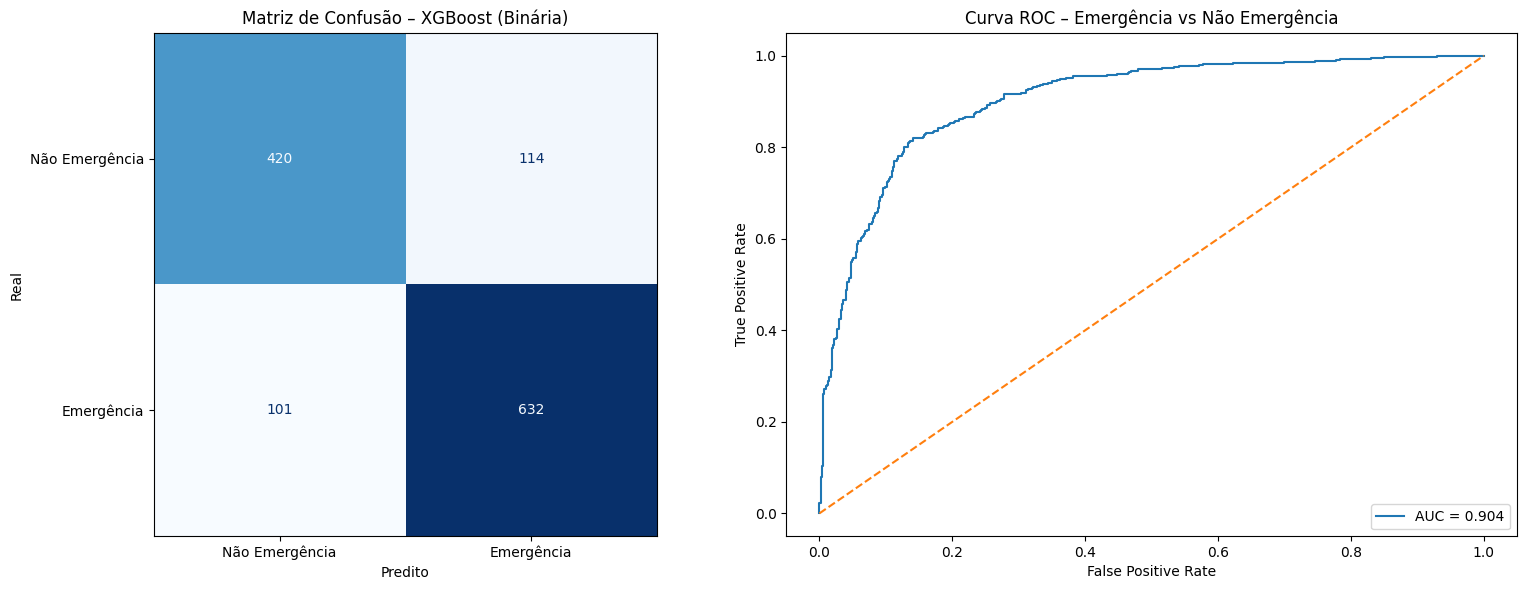

In [ ]:
from sklearn.metrics import roc_curve, auc

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# MATRIZ DE CONFUSÃO =====
class_names = ["Não Emergência", "Emergência"]

cm = confusion_matrix(y_true_concat, y_pred_concat)

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=class_names
)

disp.plot(
    ax=axes[0],
    cmap="Blues",
    values_format="d",
    colorbar=False
)

axes[0].set_title("Matriz de Confusão – XGBoost (Binária)")
axes[0].set_xlabel("Predito")
axes[0].set_ylabel("Real")


fpr, tpr, _ = roc_curve(y_true_concat, y_proba_concat)
roc_auc = auc(fpr, tpr)

axes[1].plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
axes[1].plot([0, 1], [0, 1], linestyle="--")

axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("Curva ROC – Emergência vs Não Emergência")
axes[1].legend(loc="lower right")

plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import (
    precision_score,
    recall_score,
    balanced_accuracy_score,
    f1_score,
    cohen_kappa_score
)

print("\n" + "="*75)
print(" RESULTADO FINAL – XGBOOST (Binário | Stratified K-Fold)")
print("="*75)

prec_scores = []
rec_scores = []
bal_acc_scores = []
f1_macro_scores = []
kappa_scores = []

for y_t, y_pb in zip(y_true_all, y_proba_all):
    y_pred = (y_pb >= 0.5).astype(int)

    prec_scores.append(
        precision_score(y_t, y_pred, average="weighted", zero_division=0)
    )
    rec_scores.append(
        recall_score(y_t, y_pred, average="weighted", zero_division=0)
    )
    bal_acc_scores.append(
        balanced_accuracy_score(y_t, y_pred)
    )
    f1_macro_scores.append(
        f1_score(y_t, y_pred, average="macro")
    )
    kappa_scores.append(
        cohen_kappa_score(y_t, y_pred)
    )

print(f"Acurácia média           : {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"F1-score médio           : {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
print(f"Precisão (weighted)      : {np.mean(prec_scores):.4f}")
print(f"Recall (weighted)        : {np.mean(rec_scores):.4f}")
print(f"Acurácia balanceada      : {np.mean(bal_acc_scores):.4f}")
print(f"F1-score (macro)         : {np.mean(f1_macro_scores):.4f}")
print(f"Cohen’s Kappa            : {np.mean(kappa_scores):.4f}")
print(f"AUC média                : {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")



 RESULTADO FINAL – XGBOOST (Binário | Stratified K-Fold)
Acurácia média           : 0.8303 ± 0.0206
F1-score médio           : 0.8545 ± 0.0177
Precisão (weighted)      : 0.8317
Recall (weighted)        : 0.8303
Acurácia balanceada      : 0.8244
F1-score (macro)         : 0.8252
Cohen’s Kappa            : 0.6508
AUC média                : 0.9041 ± 0.0099


O modelo XGBoost apresentou desempenho elevado na tarefa de classificação binária entre casos de emergência e não emergência, evidenciando boa capacidade de generalização e consistência ao longo dos folds da validação cruzada estratificada. A acurácia média obtida foi de 0,8303 ± 0,0206, indicando que aproximadamente 83% das predições foram realizadas corretamente, com variação relativamente baixa entre as partições dos dados.

O F1-score médio de 0,8545 ± 0,0177 indica um bom equilíbrio entre precisão e recall, sugerindo que o modelo é capaz de identificar adequadamente tanto pacientes urgentes quanto não urgentes. A acurácia balanceada (0,8244) e o F1-score macro (0,8252) reforçam que o desempenho do modelo se mantém consistente entre as classes, mesmo diante do possível desbalanceamento presente nos dados de triagem clínica.

O coeficiente de Cohen’s Kappa (0,6508) aponta uma concordância substancial entre as previsões do modelo e os rótulos reais, acima do que seria esperado ao acaso, evidenciando que o algoritmo captura padrões relevantes nos dados clínicos.

A análise da matriz de confusão mostra que o modelo apresenta elevada taxa de acerto na identificação de casos de emergência, com 632 verdadeiros positivos, ao custo de 101 falsos negativos, caracterizando situações de subtriagem (undertriage). Por outro lado, foram observados 114 falsos positivos, representando casos de sobretriagem (overtriage). Esse padrão sugere que o modelo apresenta boa sensibilidade para casos graves, embora ainda existam erros clinicamente relevantes.

A curva ROC apresenta AUC média de 0,9041, indicando excelente capacidade discriminativa do modelo. Em termos práticos, isso significa que o XGBoost é capaz de distinguir de forma eficaz entre pacientes urgentes e não urgentes, atribuindo maiores probabilidades de emergência aos casos realmente graves.

Em síntese, os resultados indicam que o modelo XGBoost apresenta desempenho robusto e consistente na classificação binária de pacientes, com alta capacidade discriminativa e bom equilíbrio entre sensibilidade e especificidade. Esses achados reforçam o potencial do modelo como ferramenta de apoio à decisão clínica em contextos de triagem hospitalar, desde que utilizado de forma complementar à avaliação realizada por profissionais de saúde.

## XGBoost com Classificação Multiclasse

### Treinamento

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, f1_score, accuracy_score
from xgboost import XGBClassifier
import numpy as np
import pandas as pd

# Target (multiclasse KTAS 1..5)
le = LabelEncoder()
y = le.fit_transform(df_legendas["KTAS_expert"])  # agora y vira 0..K-1 automaticamente

# Features
X = df_legendas.drop(columns=[
    "KTAS_Especialista_classe",
    "KTAS_Enfermeiro_classe",
    "KTAS_expert",
    "Permanencia_Categoria",
    "Erro_Tipo_Triagem",
    "Desfecho_legenda",
    "Diagnosis in ED",
    "KTAS_RN",
    "Chief_complain"
])

X = pd.get_dummies(X, drop_first=True)
X = pd.concat([X, tfidf_df], axis=1)

# CV
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

acc_scores = []
f1_scores = []
y_true_all = []
y_proba_all = []

# nomes das classes para report
target_names = le.classes_.astype(str)
num_classes = len(target_names)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y), 1):
    print(f"\n🔁 Fold {fold}")

    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    xgb = XGBClassifier(
        n_estimators=300,
        max_depth=6,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softprob",
        num_class=num_classes,
        eval_metric="mlogloss",
        random_state=42,
        n_jobs=-1,
        tree_method="hist"
    )

    xgb.fit(X_train, y_train)

    # Predições (forma mais segura)
    y_proba = xgb.predict_proba(X_test)      # (n, K)
    y_pred = np.argmax(y_proba, axis=1)      # (n,)

    print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

    acc_scores.append(accuracy_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred, average="weighted"))

    y_true_all.append(y_test)
    y_proba_all.append(y_proba)

print("\n✅ Resultado final (média ± desvio padrão)")
print(f"Acurácia: {np.mean(acc_scores):.4f} ± {np.std(acc_scores):.4f}")
print(f"F1 (weighted): {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")



🔁 Fold 1
              precision    recall  f1-score   support

           1     0.2857    0.4000    0.3333         5
           2     0.4884    0.4773    0.4828        44
           3     0.6827    0.7245    0.7030        98
           4     0.7835    0.8261    0.8042        92
           5     0.6667    0.1333    0.2222        15

    accuracy                         0.6772       254
   macro avg     0.5814    0.5122    0.5091       254
weighted avg     0.6768    0.6772    0.6658       254


🔁 Fold 2
              precision    recall  f1-score   support

           1     1.0000    0.5000    0.6667         6
           2     0.7419    0.5227    0.6133        44
           3     0.6726    0.7835    0.7238        97
           4     0.7300    0.7935    0.7604        92
           5     0.4286    0.2000    0.2727        15

    accuracy                         0.7008       254
   macro avg     0.7146    0.5599    0.6074       254
weighted avg     0.6987    0.7008    0.6899       254


🔁

### Análise dos Resultados do XGBoost Multiclasse

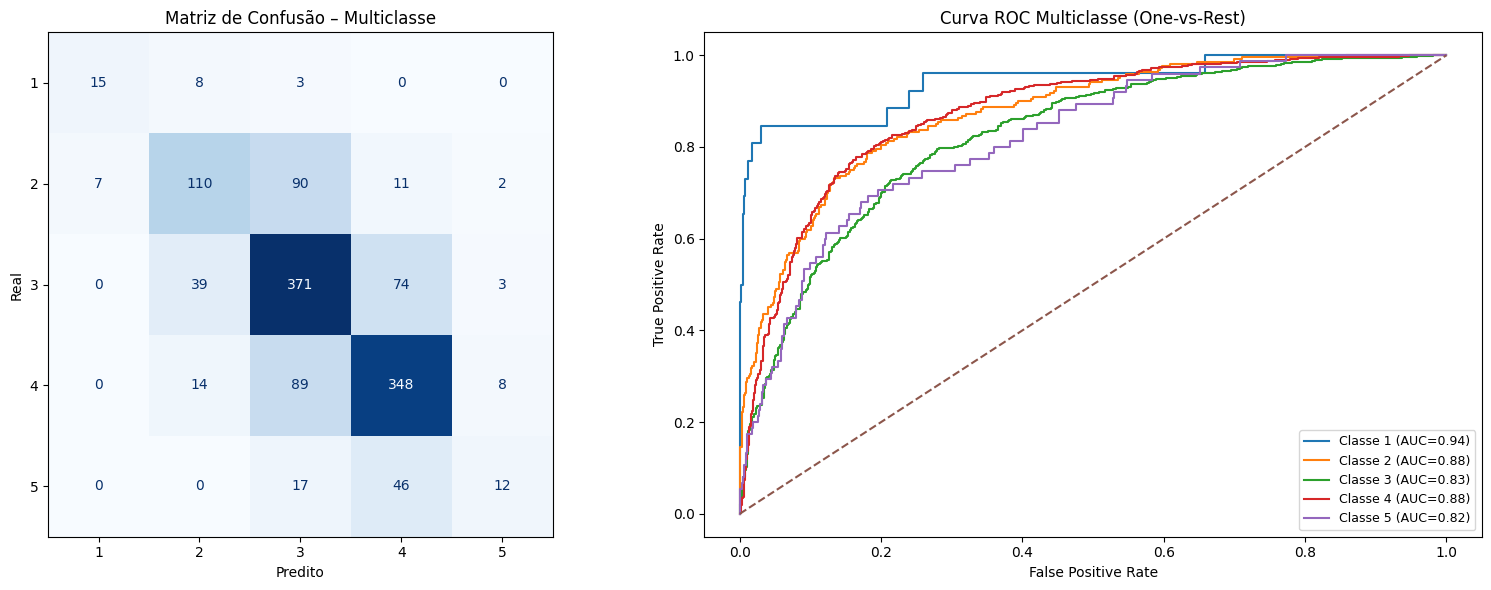

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Garantias (evita bugs silenciosos)
y_true_concat = np.asarray(y_true_concat)
y_pred_concat = np.asarray(y_pred_concat)
y_proba_concat = np.asarray(y_proba_concat)

classes = np.arange(y_proba_concat.shape[1])   # [0,1,2,...,K-1]
n_classes = len(classes)

assert y_proba_concat.shape[1] == len(class_names), "class_names precisa ter o mesmo tamanho de K (n_classes)"
assert y_true_concat.min() >= 0 and y_true_concat.max() < n_classes, "y_true_concat deve estar em 0..K-1"

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1) MATRIZ DE CONFUSÃO
cm = confusion_matrix(y_true_concat, y_pred_concat, labels=classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(ax=axes[0], cmap="Blues", values_format="d", colorbar=False)

axes[0].set_title("Matriz de Confusão – Multiclasse")
axes[0].set_xlabel("Predito")
axes[0].set_ylabel("Real")

# 2) CURVA ROC MULTICLASSE (OvR)
y_true_bin = label_binarize(y_true_concat, classes=classes)

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_proba_concat[:, i])
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, label=f"Classe {class_names[i]} (AUC={roc_auc:.2f})")

axes[1].plot([0, 1], [0, 1], linestyle="--")
axes[1].set_xlabel("False Positive Rate")
axes[1].set_ylabel("True Positive Rate")
axes[1].set_title("Curva ROC Multiclasse (One-vs-Rest)")
axes[1].legend(loc="lower right", fontsize=9)

plt.tight_layout()
plt.show()


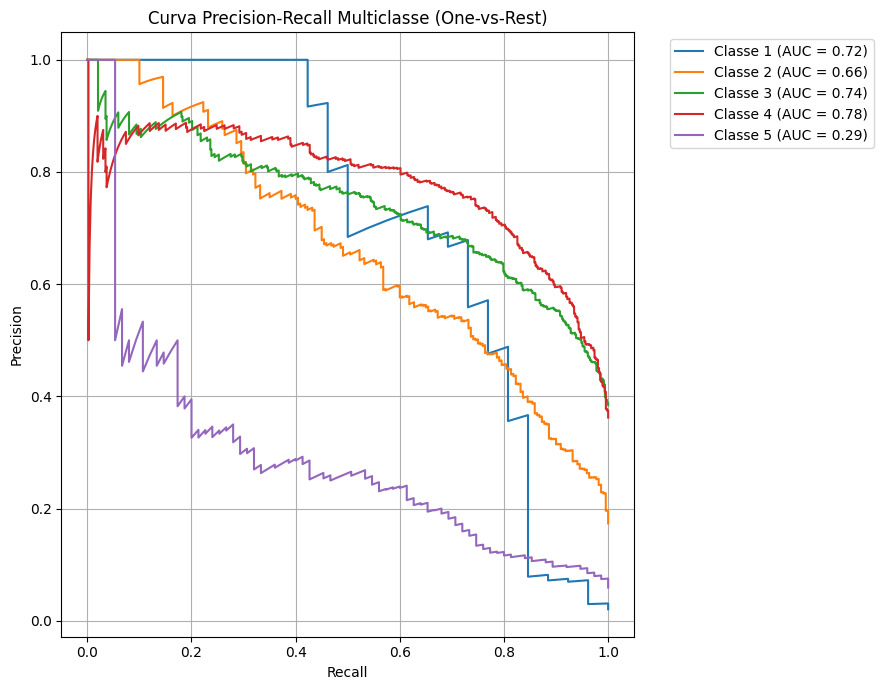

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, auc
from sklearn.preprocessing import label_binarize

# Garantias
y_true_concat = np.asarray(y_true_concat)
y_proba_concat = np.asarray(y_proba_concat)

classes = np.arange(y_proba_concat.shape[1])   # [0..K-1]
n_classes = len(classes)

assert y_proba_concat.shape[1] == len(class_names), "class_names precisa ter K elementos"

# Binariza o y verdadeiro (OvR)
y_true_bin = label_binarize(y_true_concat, classes=classes)

plt.figure(figsize=(9, 7))

for i in range(n_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_proba_concat[:, i])
    pr_auc = auc(recall, precision)

    plt.plot(recall, precision, label=f"Classe {class_names[i]} (AUC = {pr_auc:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall Multiclasse (One-vs-Rest)")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    cohen_kappa_score
)
import numpy as np

print("\n" + "="*80)
print(" RESULTADO FINAL – XGBOOST (Multiclasse | Stratified K-Fold)")
print("="*80)

acc_scores_final = []
bal_acc_scores = []
prec_scores = []
rec_scores = []
f1_weighted_scores = []
f1_macro_scores = []
kappa_scores = []
auc_scores = []

for y_t, y_pb in zip(y_true_all, y_proba_all):

    # Classe predita (multiclasse)
    y_pred = np.argmax(y_pb, axis=1)

    acc_scores_final.append(accuracy_score(y_t, y_pred))
    bal_acc_scores.append(balanced_accuracy_score(y_t, y_pred))

    prec_scores.append(precision_score(y_t, y_pred, average="weighted", zero_division=0))
    rec_scores.append(recall_score(y_t, y_pred, average="weighted", zero_division=0))

    f1_weighted_scores.append(f1_score(y_t, y_pred, average="weighted"))
    f1_macro_scores.append(f1_score(y_t, y_pred, average="macro"))

    kappa_scores.append(cohen_kappa_score(y_t, y_pred))

    # AUC multiclasse OvR (weighted) – usando y_t direto (mais correto)
    auc_scores.append(roc_auc_score(y_t, y_pb, multi_class="ovr", average="weighted"))

print(f"Acurácia média              : {np.mean(acc_scores_final):.4f} ± {np.std(acc_scores_final):.4f}")
print(f"Acurácia balanceada         : {np.mean(bal_acc_scores):.4f} ± {np.std(bal_acc_scores):.4f}")
print(f"Precisão (weighted)         : {np.mean(prec_scores):.4f}")
print(f"Recall (weighted)           : {np.mean(rec_scores):.4f}")
print(f"F1-score (weighted)         : {np.mean(f1_weighted_scores):.4f}")
print(f"F1-score (macro)            : {np.mean(f1_macro_scores):.4f}")
print(f"Cohen’s Kappa               : {np.mean(kappa_scores):.4f}")
print(f"AUC (OVR, weighted)         : {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")



 RESULTADO FINAL – XGBOOST (Multiclasse | Stratified K-Fold)
Acurácia média              : 0.6756 ± 0.0183
Acurácia balanceada         : 0.5520 ± 0.0504
Precisão (weighted)         : 0.6729
Recall (weighted)           : 0.6756
F1-score (weighted)         : 0.6629
F1-score (macro)            : 0.5752
Cohen’s Kappa               : 0.5120
AUC (OVR, weighted)         : 0.8558 ± 0.0116


O modelo XGBoost foi avaliado na tarefa de classificação multiclasse dos níveis de gravidade KTAS (1 a 5) utilizando validação cruzada estratificada. A acurácia média obtida foi de 0,6756 ± 0,0183, indicando um desempenho global ligeiramente superior ao acaso, com variação relativamente baixa entre os folds. A acurácia balanceada de 0,5520 ± 0,0504, entretanto, revela que o desempenho do modelo não é homogêneo entre as classes, sugerindo maior dificuldade em identificar corretamente as classes menos representadas.

O F1-score ponderado (0,6629) reflete um desempenho adequado nas classes mais frequentes, enquanto o F1-score macro (0,5752) evidencia limitações na classificação equilibrada entre todas as categorias. Esse comportamento é reforçado pelo valor de Cohen’s Kappa (0,5120), que indica concordância moderada entre as predições do modelo e os rótulos reais, acima do acaso, mas ainda distante de um desempenho ideal para aplicações clínicas sensíveis.

Análise da matriz de confusão

A matriz de confusão mostra que o XGBoost apresenta maior taxa de acerto nas classes intermediárias, especialmente KTAS 3 e KTAS 4, que concentram a maior parte das classificações corretas. Observa-se, no entanto, confusão significativa entre classes adjacentes, particularmente entre KTAS 2 e KTAS 3, bem como entre KTAS 3 e KTAS 4. Esse padrão indica que o modelo captura a progressão ordinal da gravidade, mas apresenta dificuldade em estabelecer fronteiras precisas entre níveis clínicos próximos.

As classes extremas (KTAS 1 e KTAS 5) apresentam maior taxa de erro, o que pode ser atribuído ao menor número de amostras disponíveis e à maior variabilidade clínica desses grupos. Em particular, a classe KTAS 5 apresenta confusões frequentes com KTAS 4, sugerindo tendência do modelo à sobretriagem de casos menos urgentes.

Análise da curva ROC multiclasse

A curva ROC multiclasse no esquema One-vs-Rest indica boa capacidade discriminativa global, com AUC ponderada de 0,8558 ± 0,0116. Destaca-se o desempenho elevado na classe KTAS 1 (AUC ≈ 0,94), evidenciando boa capacidade do modelo em identificar casos críticos. As classes intermediárias (KTAS 2, 3 e 4) apresentam AUCs entre 0,83 e 0,88, enquanto a classe KTAS 5 mantém desempenho ligeiramente inferior, refletindo maior sobreposição com classes adjacentes.

Análise da curva Precision-Recall

A curva Precision-Recall fornece uma visão mais informativa sobre o desempenho em um cenário de desbalanceamento de classes. Observa-se desempenho satisfatório nas classes KTAS 1, 3 e 4, com valores de AUC-PR variando entre 0,72 e 0,78, indicando bom equilíbrio entre precisão e recall. Em contraste, a classe KTAS 5 apresenta AUC-PR significativamente inferior (≈ 0,29), evidenciando grande dificuldade do modelo em identificar corretamente pacientes de baixa urgência, o que reforça a influência do desbalanceamento e da sobreposição de características clínicas.

Síntese dos resultados

Em síntese, os resultados indicam que o modelo XGBoost apresenta desempenho moderado no cenário multiclasse, com boa capacidade discriminativa global, especialmente para casos mais graves, mas limitações relevantes na classificação equilibrada entre todas as classes. A tendência de confusão entre classes adjacentes e o baixo desempenho nas classes menos representadas ressaltam a complexidade da tarefa de triagem multiclasse e indicam que, embora o XGBoost seja um modelo robusto, sua aplicação em cenários clínicos reais deve ser cuidadosamente avaliada, preferencialmente como ferramenta de apoio à decisão.

# Análise Comparativa: XGBoost vs Random Forest na Classificação Binária

O modelo XGBoost apresentou desempenho elevado na tarefa de classificação binária entre casos de emergência e não emergência, evidenciando boa capacidade de generalização e consistência ao longo dos folds da validação cruzada estratificada. A acurácia média obtida foi de 0,8303 ± 0,0206, indicando que aproximadamente 83% das predições foram realizadas corretamente, com variação relativamente baixa entre as partições dos dados.

O F1-score médio de 0,8545 ± 0,0177 indica um bom equilíbrio entre precisão e recall, sugerindo que o modelo é capaz de identificar adequadamente tanto pacientes urgentes quanto não urgentes. A acurácia balanceada (0,8244) e o F1-score macro (0,8252) reforçam que o desempenho do modelo se mantém consistente entre as classes, mesmo diante do possível desbalanceamento presente nos dados de triagem clínica.

O coeficiente de Cohen’s Kappa (0,6508) aponta uma concordância substancial entre as previsões do modelo e os rótulos reais, acima do que seria esperado ao acaso, evidenciando que o algoritmo captura padrões relevantes nos dados clínicos.

A análise da matriz de confusão mostra que o modelo apresenta elevada taxa de acerto na identificação de casos de emergência, com 632 verdadeiros positivos, ao custo de 101 falsos negativos, caracterizando situações de subtriagem (undertriage). Por outro lado, foram observados 114 falsos positivos, representando casos de sobretriagem (overtriage). Esse padrão sugere que o modelo apresenta boa sensibilidade para casos graves, embora ainda existam erros clinicamente relevantes.

A curva ROC apresenta AUC média de 0,9041, indicando excelente capacidade discriminativa do modelo. Em termos práticos, isso significa que o XGBoost é capaz de distinguir de forma eficaz entre pacientes urgentes e não urgentes, atribuindo maiores probabilidades de emergência aos casos realmente graves.

Em síntese, os resultados indicam que o modelo XGBoost apresenta desempenho robusto e consistente na classificação binária de pacientes, com alta capacidade discriminativa e bom equilíbrio entre sensibilidade e especificidade. Esses achados reforçam o potencial do modelo como ferramenta de apoio à decisão clínica em contextos de triagem hospitalar, desde que utilizado de forma complementar à avaliação realizada por profissionais de saúde.

 # Análise Comparativa: XGBoost vs Random Forest na Classificação Multiclasse

No cenário multiclasse, envolvendo a classificação dos níveis de gravidade KTAS (1 a 5), os modelos Random Forest e XGBoost apresentaram desempenho moderado, refletindo a maior complexidade da tarefa em comparação ao cenário binário. O Random Forest obteve acurácia média de 0,6653, com acurácia balanceada de 0,6335, F1-score macro de 0,6088 e Kappa de 0,5138, indicando concordância moderada e melhor desempenho nas classes mais prevalentes. A matriz de confusão mostrou maior acerto nas classes intermediárias (KTAS 3 e 4) e maior taxa de erro nas classes extremas, especialmente devido à confusão entre categorias adjacentes. A AUC multiclasse ponderada de 0,8459 evidenciou boa capacidade discriminativa global, com destaque para a classe KTAS 1. O XGBoost apresentou desempenho global ligeiramente superior, com acurácia média de 0,6756, F1-score ponderado de 0,6629, Kappa de 0,5120 e AUC multiclasse ponderada de 0,8558, demonstrando melhor capacidade discriminativa, especialmente para casos mais graves. No entanto, a acurácia balanceada (0,5520) e o F1-score macro (0,5752) indicaram limitações na classificação equilibrada entre todas as classes, com confusão frequente entre níveis adjacentes e baixo desempenho na classe KTAS 5, evidenciado pela curva Precision-Recall. Em conjunto, os resultados confirmam que ambos os modelos capturam a progressão ordinal da gravidade clínica, mas enfrentam dificuldades na discriminação fina entre classes próximas e menos representadas, reforçando a complexidade da triagem multiclasse e a necessidade de abordagens mais refinadas para aplicação clínica.